# Sex-Specific Alzheimer's Disease Modelling Experimentations

## Data Set-up

In [4]:
# === Load and clean data ===
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, balanced_accuracy_score
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel
from scipy import stats
import random

from statistics import mean, stdev, NormalDist, StatisticsError
from math import sqrt


In [5]:
# Set random seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [6]:
# Load OASIS dataset
df = pd.read_csv("oasis_longitudinal.csv")

## Initial Data Exploration and Cleaning

In [8]:
# Display simple attributes
df.head()
df.shape
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject ID  373 non-null    object 
 1   MRI ID      373 non-null    object 
 2   Group       373 non-null    object 
 3   Visit       373 non-null    int64  
 4   MR Delay    373 non-null    int64  
 5   M/F         373 non-null    object 
 6   Hand        373 non-null    object 
 7   Age         373 non-null    int64  
 8   EDUC        373 non-null    int64  
 9   SES         354 non-null    float64
 10  MMSE        371 non-null    float64
 11  CDR         373 non-null    float64
 12  eTIV        373 non-null    int64  
 13  nWBV        373 non-null    float64
 14  ASF         373 non-null    float64
dtypes: float64(5), int64(5), object(5)
memory usage: 43.8+ KB


In [9]:
# Check for missing values
df.isnull().sum()

Subject ID     0
MRI ID         0
Group          0
Visit          0
MR Delay       0
M/F            0
Hand           0
Age            0
EDUC           0
SES           19
MMSE           2
CDR            0
eTIV           0
nWBV           0
ASF            0
dtype: int64

In [10]:
# Check for duplicates
df.duplicated().sum()

0

In [11]:
# Fill missing SES and MMSE values
df['SES'] = df['SES'].fillna(df['SES'].median())
df['MMSE'] = df['MMSE'].fillna(df['MMSE'].mean())

In [12]:
# Convert labels to binary classification: demented = 1, nondemented = 0
df['Group'] = df['Group'].replace("Converted", "Demented")
df['Group'] = df['Group'].map({"Demented": 1, "Nondemented": 0})

In [13]:
# Define features and dropping missing values
my_features = ['Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF']
df_clean = df.dropna(subset=my_features + ['Group', 'M/F'])

In [14]:
pd.crosstab(df['M/F'], df['Group'])

Group,0,1
M/F,,
F,129,84
M,61,99


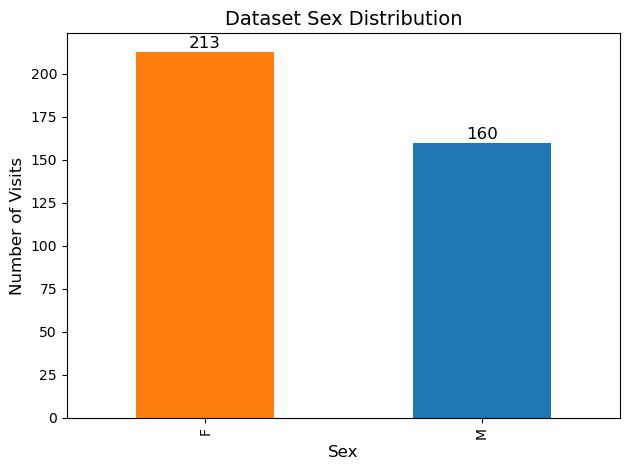

In [15]:
# Visualise sex distribution of data

counts = df_clean['M/F'].value_counts()
colours = ['tab:blue' if sex == 'M' else 'tab:orange' for sex in counts.index]
ax = counts.plot(kind='bar', color=colours)
for i, val in enumerate(counts):
    ax.text(i, val + 0.5, str(val), ha='center', va='bottom', fontsize=12)
ax.set_ylabel('Number of Visits', fontsize=12)
ax.set_xlabel('Sex', fontsize=12)
ax.set_title('Dataset Sex Distribution', fontsize=14)
plt.tight_layout()
plt.show()


## Repeated Train/Test Evaluation Function

In [17]:

# === REPEATED TRAIN/TEST EVALUATION ===

evaluation_outputs = {}

def repeated_evaluation(model, X, y, label, sex=None, sex_filter=None, groups=None, n_splits=5, n_repeats=5):
    fold_metrics = []
    y_true_folds = []
    y_proba_folds = []
    for repeat in range(n_repeats):
        sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED + repeat)
        for fold, (train_idx, test_idx) in enumerate(sgkf.split(X, y, groups)):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            scaler = StandardScaler() 
            X_train_scaled = scaler.fit_transform(X_train) 
            X_test_scaled = scaler.transform(X_test)
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
            y_proba = model.predict_proba(X_test_scaled)[:, 1]
            if sex is not None and sex_filter is not None:
                test_sex = sex.iloc[test_idx]
                mask = test_sex == sex_filter
                if not mask.any():
                    continue
                y_test = y_test[mask]
                y_pred = y_pred[mask]
                y_proba = y_proba[mask]
            y_true_folds.append(y_test.values)
            y_proba_folds.append(y_proba)
            fold_metrics.append({
                'repeat': repeat,
                'fold': fold,
                'accuracy': accuracy_score(y_test, y_pred),
                'balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
                'f1': f1_score(y_test, y_pred),
                'precision': precision_score(y_test, y_pred),
                'recall': recall_score(y_test, y_pred),
                'roc_auc': roc_auc_score(y_test, y_proba),
                'y_true': y_test.values,
                'y_proba': y_proba
            })

    metrics_df = pd.DataFrame(fold_metrics)
    metrics_df.attrs['y_true_all'] = np.concatenate(y_true_folds)
    metrics_df.attrs['y_proba_all'] = np.concatenate(y_proba_folds)
    evaluation_outputs[label] = metrics_df
    metrics = metrics_df[['accuracy', 'balanced_accuracy','f1', 'precision', 'recall', 'roc_auc']]
    means = metrics.mean()
    stds = metrics.std()
    summary = [
        label,
        means['accuracy'], stds['accuracy'],
        means['balanced_accuracy'], stds['balanced_accuracy'],
        means['f1'], stds['f1'],
        means['precision'], stds['precision'],
        means['recall'], stds['recall'],
        means['roc_auc'], stds['roc_auc']
    ]
   
    return summary, metrics_df

In [18]:

X_all = df_clean[my_features]
y_all = df_clean['Group']
sex_all = df_clean['M/F']
groups_all = df_clean['Subject ID']

## Logistic Regression and Random Forest Classifier Models

In [20]:

# === General LR models ===
LR_RF_results = []
results_folds = {}

summary, folds = repeated_evaluation(LogisticRegression(max_iter=1000), X_all, y_all, "Gen-LR-All", groups=groups_all)
LR_RF_results.append(summary)
results_folds["Gen-LR-All"] = folds
summary, folds = repeated_evaluation(LogisticRegression(max_iter=1000), X_all, y_all, "Gen-LR-M", sex=sex_all, sex_filter='M', groups=groups_all)
LR_RF_results.append(summary)
results_folds["Gen-LR-M"] = folds
summary, folds = repeated_evaluation(LogisticRegression(max_iter=1000), X_all, y_all, "Gen-LR-F", sex=sex_all, sex_filter='F', groups=groups_all)
LR_RF_results.append(summary)
results_folds["Gen-LR-F"] = folds


In [21]:
# === General RF models ===

summary, folds = repeated_evaluation(RandomForestClassifier(n_estimators=100, random_state=42), X_all, y_all, "Gen-RF-All", groups=groups_all)
LR_RF_results.append(summary)
results_folds["Gen-RF-All"] = folds
summary, folds = repeated_evaluation(RandomForestClassifier(n_estimators=100, random_state=42), X_all, y_all, "Gen-RF-M", sex=sex_all, sex_filter='M', groups=groups_all)
LR_RF_results.append(summary)
results_folds["Gen-RF-M"] = folds
summary, fold = repeated_evaluation(RandomForestClassifier(n_estimators=100, random_state=42), X_all, y_all, "Gen-RF-F", sex=sex_all, sex_filter='F', groups=groups_all)
LR_RF_results.append(summary)
results_folds["Gen-RF-F"] = folds

In [22]:

# === Sex specific models ===

df_male = df_clean[df_clean['M/F'] == 'M']
df_female = df_clean[df_clean['M/F'] == 'F']
groups_f = df_female['Subject ID']
groups_m = df_male['Subject ID']

X_m, y_m = df_male[my_features], df_male['Group']
X_f, y_f = df_female[my_features], df_female['Group']


summary, folds = repeated_evaluation(LogisticRegression(max_iter=1000), X_m, y_m, "Male-LR-M", groups=groups_m)
LR_RF_results.append(summary)
results_folds["Male-LR-M"] = folds
summary, folds = repeated_evaluation(LogisticRegression(max_iter=1000), X_f, y_f, "Female-LR-F", groups=groups_f)
LR_RF_results.append(summary)
results_folds["Female-LR-F"] = folds


summary, folds = repeated_evaluation(RandomForestClassifier(n_estimators=100, random_state=42), X_m, y_m, "Male-RF-M", groups=groups_m)
LR_RF_results.append(summary)
results_folds["Male-RF-M"] = folds
summary, folds = repeated_evaluation(RandomForestClassifier(n_estimators=100, random_state=42), X_f, y_f, "Female-RF-F", groups=groups_f)
LR_RF_results.append(summary)
results_folds["Female-RF-F"] = folds

In [23]:

# === Results Table ===
columns =['Model', 'Accuracy_mean', 'Accuracy_std', 'BalancedAccuracy_mean', 'BalancedAccuracy_std', 'F1_mean', 'F1_std', 'Precision_mean', 'Precision_std', 'Recall_mean', 'Recall_std', 'AUC_mean', 'AUC_std']
results_table = pd.DataFrame(LR_RF_results, columns=columns)
n_splits, n_repeats = 5, 5
metrics = ['Accuracy', 'BalancedAccuracy', 'F1', 'Precision', 'Recall', 'AUC']
N = n_splits * n_repeats
for metric in metrics:
    se = results_table[f'{metric}_std'] / np.sqrt(N)
    results_table[f'{metric}_ci_lower'] = results_table[f'{metric}_mean'] - 1.96 * se
    results_table[f'{metric}_ci_upper'] = results_table[f'{metric}_mean'] + 1.96 * se
print(results_table)


         Model  Accuracy_mean  Accuracy_std  BalancedAccuracy_mean  \
0   Gen-LR-All       0.945927      0.021990               0.945203   
1     Gen-LR-M       0.956230      0.034544               0.959778   
2     Gen-LR-F       0.936758      0.036278               0.920672   
3   Gen-RF-All       0.936700      0.032105               0.936656   
4     Gen-RF-M       0.942454      0.041098               0.947694   
5     Gen-RF-F       0.930820      0.041843               0.916428   
6    Male-LR-M       0.940504      0.056473               0.944560   
7  Female-LR-F       0.941202      0.046862               0.926524   
8    Male-RF-M       0.921182      0.047376               0.920360   
9  Female-RF-F       0.925408      0.044427               0.912515   

   BalancedAccuracy_std   F1_mean    F1_std  Precision_mean  Precision_std  \
0              0.019437  0.941873  0.021347        0.985003       0.016447   
1              0.031670  0.961849  0.031498        0.977290       0.03263

## XGBOOST models

In [25]:
xgb_results = []
xgb_fold_results = {}
xgb_model = XGBClassifier(eval_metric='logloss', random_state=RANDOM_SEED)

summary, folds = repeated_evaluation(xgb_model, X_all, y_all, 'Gen-XGB-All', groups=groups_all)
xgb_results.append(summary)
xgb_fold_results['Gen-XGB-All'] = folds
summary, folds = repeated_evaluation(xgb_model, X_all, y_all, 'Gen-XGB-M', sex=sex_all, sex_filter='M', groups=groups_all)
xgb_results.append(summary)
xgb_fold_results['Gen-XGB-M'] = folds
summary, folds = repeated_evaluation(xgb_model, X_all, y_all, 'Gen-XGB-F', sex=sex_all, sex_filter='F', groups=groups_all)
xgb_results.append(summary)
xgb_fold_results['Gen-XGB-F'] = folds

summary, folds = repeated_evaluation(xgb_model, X_m, y_m, 'Male-XGB-M', groups=groups_m)
xgb_results.append(summary)                  
xgb_fold_results['Male-XGB-M'] = folds
summary, folds = repeated_evaluation(xgb_model, X_f, y_f, 'Female-XGB-F', groups=groups_f)
xgb_results.append(summary)                  
xgb_fold_results['Female-XGB-F'] = folds


In [26]:
xgb_results_table = pd.DataFrame(xgb_results, columns=columns)
n_splits, n_repeats = 5, 5
N = n_splits * n_repeats
for metric in metrics:
    se = xgb_results_table[f'{metric}_std'] / np.sqrt(N)
    xgb_results_table[f'{metric}_ci_lower'] = xgb_results_table[f'{metric}_mean'] - 1.96 * se
    xgb_results_table[f'{metric}_ci_upper'] = xgb_results_table[f'{metric}_mean'] + 1.96 * se
print(xgb_results_table)

          Model  Accuracy_mean  Accuracy_std  BalancedAccuracy_mean  \
0   Gen-XGB-All       0.924207      0.032219               0.923985   
1     Gen-XGB-M       0.932946      0.040311               0.932501   
2     Gen-XGB-F       0.916102      0.051078               0.905260   
3    Male-XGB-M       0.934569      0.041945               0.931787   
4  Female-XGB-F       0.897126      0.048042               0.887686   

   BalancedAccuracy_std   F1_mean    F1_std  Precision_mean  Precision_std  \
0              0.031405  0.918348  0.038928        0.931866       0.060328   
1              0.039599  0.940016  0.043949        0.936216       0.072513   
2              0.058145  0.883848  0.079170        0.921859       0.094487   
3              0.052695  0.944242  0.038053        0.936750       0.064299   
4              0.049068  0.861063  0.061203        0.889981       0.090041   

   Recall_mean  ...  BalancedAccuracy_ci_lower  BalancedAccuracy_ci_upper  \
0     0.907490  ...        

## Support Vector Machine and Voting Classifier Models 

In [28]:
svm_model = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=RANDOM_SEED)

svm_vote_results = []
svm_vote_fold_results = {}

# === SVM general models ===
summary, folds = repeated_evaluation(svm_model, X_all, y_all, 'Gen-SVM-All', groups=groups_all)
svm_vote_results.append(summary)
svm_vote_fold_results['Gen-SVM-All'] = folds
summary, folds = repeated_evaluation(svm_model, X_all, y_all, 'Gen-SVM-M', sex=sex_all, sex_filter='M', groups=groups_all)
svm_vote_results.append(summary)
svm_vote_fold_results['Gen-SVM-M'] = folds
summary, folds = repeated_evaluation(svm_model, X_all, y_all, 'Gen-SVM-F', sex=sex_all, sex_filter='F', groups=groups_all)
svm_vote_results.append(summary)
svm_vote_fold_results['Gen-SVM-F'] = folds

# === SVM sex-specific models ===
summary, folds = repeated_evaluation(svm_model, X_m, y_m, 'Male-SVM-M', groups=groups_m)
svm_vote_results.append(summary)
svm_vote_fold_results['Male-SVM-M'] = folds

summary, folds = repeated_evaluation(svm_model, X_f, y_f, 'Female-SVM-F', groups=groups_f)
svm_vote_results.append(summary)
svm_vote_fold_results['Female-SVM-F'] = folds

In [29]:
# === Voting Classifier Set-up ===

voting_estimators =[
    ('lr', LogisticRegression(max_iter=1000)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED)),
    ('svm', SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=RANDOM_SEED)),
]
voting_clf = VotingClassifier(estimators=voting_estimators, voting='soft')

    

In [30]:
# === VC general models ===

summary, folds = repeated_evaluation(voting_clf, X_all, y_all, 'Gen-VC-All', groups=groups_all)
svm_vote_results.append(summary)
svm_vote_fold_results['Gen-VC-All'] = folds
summary, folds = repeated_evaluation(voting_clf, X_all, y_all, 'Gen-VC-M', sex=sex_all, sex_filter='M', groups=groups_all)
svm_vote_results.append(summary)
svm_vote_fold_results['Gen-VC-M'] = folds
summary, folds = repeated_evaluation(voting_clf, X_all, y_all, 'Gen-VC-F', sex=sex_all, sex_filter='F', groups=groups_all)
svm_vote_results.append(summary)
svm_vote_fold_results['Gen-VC-F'] = folds
                                         
# === VC sex-specific models
summary, folds = repeated_evaluation(voting_clf, X_m, y_m, 'Male-VC-M',  groups=groups_m)
svm_vote_results.append(summary)
svm_vote_fold_results['Male-VC-M'] = folds
summary, folds = repeated_evaluation(voting_clf, X_f, y_f, 'Female-VC-F', groups=groups_f)
svm_vote_results.append(summary)
svm_vote_fold_results['Female-VC-F'] = folds


In [31]:
# === SVM and VC results ===

svm_vote_results_table = pd.DataFrame(svm_vote_results, columns=columns)
n_splits, n_repeats = 5, 5
N = n_splits * n_repeats
for metric in metrics:
    se = svm_vote_results_table[f'{metric}_std'] / np.sqrt(N)
    svm_vote_results_table[f'{metric}_ci_lower'] = svm_vote_results_table[f'{metric}_mean'] - 1.96 * se
    svm_vote_results_table[f'{metric}_ci_lower'] = svm_vote_results_table[f'{metric}_mean'] + 1.96 * se
print(svm_vote_results_table)

          Model  Accuracy_mean  Accuracy_std  BalancedAccuracy_mean  \
0   Gen-SVM-All       0.943812      0.023695               0.943356   
1     Gen-SVM-M       0.955054      0.034536               0.958978   
2     Gen-SVM-F       0.933638      0.040322               0.917485   
3    Male-SVM-M       0.950382      0.045149               0.953238   
4  Female-SVM-F       0.936436      0.046164               0.920418   
5    Gen-VC-All       0.946460      0.022453               0.945650   
6      Gen-VC-M       0.956230      0.034544               0.959778   
7      Gen-VC-F       0.937446      0.035808               0.920785   
8     Male-VC-M       0.949130      0.045062               0.951225   
9   Female-VC-F       0.936505      0.045083               0.922259   

   BalancedAccuracy_std   F1_mean    F1_std  Precision_mean  Precision_std  \
0              0.021427  0.939531  0.024260        0.982592       0.024459   
1              0.032319  0.961033  0.031261        0.977229   

## Visually Assessing Model Accuracies - Initial Look

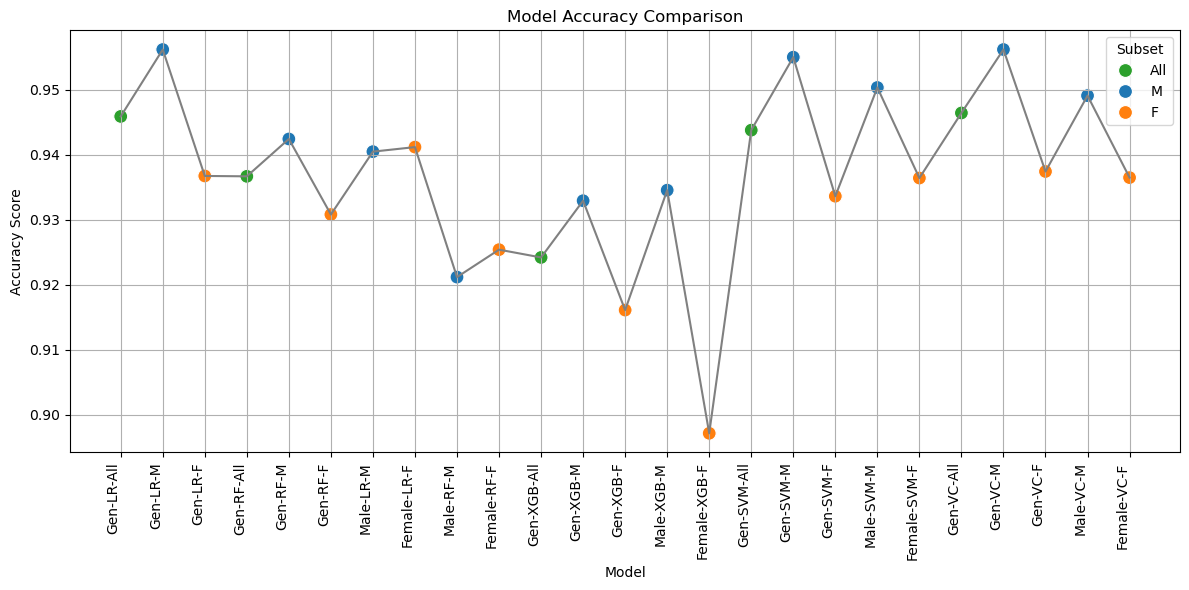

In [33]:
all_results_table = pd.concat([results_table, xgb_results_table, svm_vote_results_table], ignore_index=True)
all_results_table['Subset'] = all_results_table['Model'].str.split('-').str[-1]
palette = {'F': 'tab:orange', 'M': 'tab:blue', 'All': 'tab:green'}
plt.figure(figsize=(12,6))
plt.plot(all_results_table['Model'], all_results_table['Accuracy_mean'], color='gray')
sns.scatterplot(data=all_results_table, x='Model', y='Accuracy_mean', hue='Subset', palette=palette, s=100)
plt.xticks(rotation=90, ha='right')
plt.ylabel('Accuracy Score')
plt.title('Model Accuracy Comparison')
plt.grid(True)
plt.tight_layout()
plt.legend(title='Subset')
plt.show()

In [34]:
# Report mean balanced accuracy for each model
metric = "balanced_accuracy"
all_fold_tables = []
for results in (results_folds, xgb_fold_results, svm_vote_fold_results):
    for model_name, fold_df in results.items():
        df = fold_df.copy()
        df['Model'] = model_name
        all_fold_tables.append(df)

fold_metrics = pd.concat(all_fold_tables, ignore_index=True)


ValueError: operands could not be broadcast together with shapes (800,) (1865,) 

In [ ]:
summary = fold_metrics.groupby('Model')[metric].agg(['mean', 'std'])
for model_name, row in summary.iterrows():
    print(f"{model_name}: {row['mean']:.4f} ± {row['std']:.4f}")

In [ ]:
# Displaying Balanced Accuracy  

all_results_table['Subset'] = all_results_table['Model'].str.split('-').str[-1]
palette = {'F': 'tab:orange', 'M': 'tab:blue', 'All': 'tab:green'}
plt.figure(figsize=(12,6))
plt.plot(all_results_table['Model'], all_results_table['BalancedAccuracy_mean'], color='gray')
sns.scatterplot(data=all_results_table, x='Model', y='BalancedAccuracy_mean', hue='Subset', palette=palette, s=100)
plt.xticks(rotation=90, ha='right')
plt.ylabel('Balanced Accuracy Score')
plt.title('Model Balanced Accuracy Comparison')
plt.grid(True)
plt.tight_layout()
plt.legend(title='Subset')
plt.show()

In [41]:
# Evaluation of models

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, brier_score_loss
from sklearn.calibration import calibration_curve
from IPython.display import Image, display

def plot_roc_auc(model_probs: dict[str, np.array], y_true: np.ndarray, save_path: str | None = None) -> dict[str, float]:
    aucs: dict[str, float] = {}
    plt.figure()
    for name, prob in model_probs.items():
        fpr, tpr, _ = roc_curve(y_true, prob)
        model_auc = auc(fpr, tpr)
        aucs[name] = model_auc
        plt.plot(fpr, tpr, label=f'{name} (AUC={model_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.close()
    return aucs

def decision_curve(y_true: np.ndarray, prob: np.ndarray, thresholds: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    y_true = np.asarray(y_true)
    prob = np.asarray(prob)
    n = len(y_true)
    net_benefits = []
    for thr in thresholds:
        pred_pos = prob >= thr
        tp = np.sum((pred_pos == 1) & (y_true == 1))
        fp = np.sum((pred_pos == 1) & (y_true == 0))
        net_benefit = (tp / n) - (fp / n) * (thr / (1 - thr))
        net_benefits.append(net_benefit)
    return np.asarray(thresholds), np.asarray(net_benefits)

def plot_decision_curves(model_probs: dict[str, np.ndarray], y_true: np.ndarray, thresholds: np.ndarray | None = None, save_path: str | None = None) -> None:
    if thresholds is None:
        thresholds = np.linspace(0.01, 0.99, 99)
    plt.figure()
    for name, prob in model_probs.items():
        thr, nb = decision_curve(y_true, prob, thresholds)
        plt.plot(thr, nb, label=name)
    plt.xlabel('Threshold Probability')
    plt.ylabel('Net Benefit')
    plt.title('Decision Curve')
    plt.legend(loc='lower right')
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.close()

def reliability_diagram(y_true: np.ndarray, prob: np.ndarray, n_bins: int = 10) -> tuple[np.ndarray, np.ndarray, float]:
    frac_pos, mean_pred = calibration_curve(y_true, prob, n_bins=n_bins)
    brier = brier_score_loss(y_true, prob)
    return mean_pred, frac_pos, brier


def plot_reliability_curves(model_probs: dict[str, np.ndarray], y_true: np.ndarray, n_bins: int = 10, save_path: str | None = None) -> dict[str, float]:
    briers: dict[str, float] = {}
    plt.figure()
    for name, prob in model_probs.items():
        mean_pred, frac_pos, brier = reliability_diagram(y_true, prob, n_bins=n_bins)
        briers[name] = brier
        plt.plot(mean_pred, frac_pos, marker='o', label=f'{name} (Brier={brier:.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title('Reliability Diagram')
    plt.legend(loc='upper left')
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.close()
    return briers



In [ ]:
## Generate predictions of each model and sex subgroup 



In [45]:

# === GENERATE MODEL PLOTS ===

for label, df in evaluation_outputs.items():
    y_true = np.concatenate(df['y_true'].to_numpy())
    y_proba = np.concatenate(df['y_proba'].to_numpy())
    model_probs = {label: y_proba}
    plot_roc_auc(model_probs, y_true)
    plot_decision_curves(model_probs, y_true)
    plot_reliability_curves(model_probs, y_true)

    


#### TODO
#from scipy.stats import ttest_rel
#import pandas as pd

# Extract AUC scores for each model from the earlier results
# Define model pairs to compare
# Perform t-tests
# Bonferroni correction

# Evaluate all models with cross validation??